# Lab 2: GPs for Non-Gaussian Likelihoods and Big Data
### Gaussian Process Summer School 2018
#### <span style="color:red"> Note from Teddy: ONLY Sparse GPs</span>
_written by Fariba Yousefi, Juan José Giraldo, and Wil Ward, adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/), [Neil Lawrence](http://inverseprobability.com/), and [James Hensman](http://jameshensman.github.io/)_

This lab introduces Gaussian process regression for data with non-Gaussian likelihoods, and shows how this can be applied to classification. The concept of sparse methods for Gaussian process regression is introduced for creating a scalable regression model, and this is combined with a large classification problem.

As with Lab 1, the notebook uses `GPy` for handling the regression model and likelihoods.

##  1. Getting started

You should be using Python 3.5 (or above), and have `GPy` installed.

First we setup our notebook with the libraries we are going to use. As with Lab 1, we use `numpy` for maths functionality, `pyplot` for plotting, and `GPy` for Gaussian processes.

In [ ]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/). We will be using GPy to define our kernels, and regression. Note that `GPy` also contains plotting utilities, but we will not use these in this lab.

We will recycle our GP plotting utility from Lab 1:

In [9]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)), # 95% confidence interval of a Gaussian is
                     m[:,0] + 1.96*np.sqrt(np.diag(C)), # .. contained within mean +/- 1.96*s.d.
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

### Full versus Sparse Gaussian Process Regression

In the following example, we will simulate some observations sampled from a GP, and compare the results of sparse and full regression.

First we will generate $N=50$ samples from a GP:

In [10]:
# This is important for reproducing the latent function
np.random.seed(40918)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Create a smooth GP latent function
X = np.sort(np.random.rand(50, 1), 0)
y = np.random.multivariate_normal(np.zeros(50), k.K(X,X) + 0.01*np.eye(50))[:, None]

While $N=50$ is not a _huge_ number of data, this example will show that we can get a reasonably accurate fit with only a small number of inducing variables, $M=3$. This will reduce the complexity of full GP regression, $\mathscr{O}(N^3)$, to $\mathscr{O}(NM^2)$, which is clearly a useful reduction in computational requirements &ndash; even in this basic example, we can see $450 \ll 125000$.

We make use of the `SparseGPRegression` model which, like the `GPRegression` model, has sensible defaults that we don't need to worry about for this example. The `SparseGPRegression` assumes a Gaussian likelihood and uses exact Gaussian inference. We could also define these explicitly using `core.SVGP`, which is the sparse equivalent of `core.GP` that we used above, allowing us to define the inference method, and likelihood.

<span style="color:red">Teddy Note: maybe have the optimisation after the gp without optimisation of the inducing points and introduce the theory as per the paper as well </span>

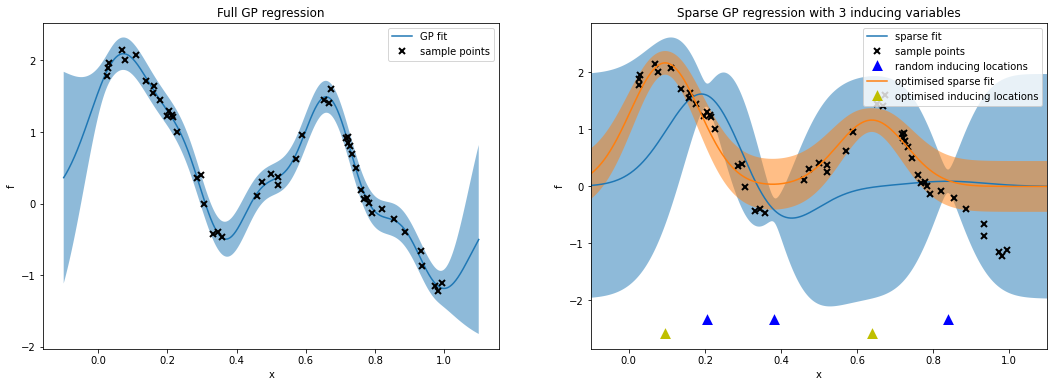

In [11]:
# Our sample space for predictions from the posterior
Xnew = np.linspace(-0.1, 1.1, 1000)[:, None]

# The covariance we used to generate the samples (assumed)
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Prepare figure enviroment
plt.figure(figsize=(18, 6))

plt.subplot(121)
## First we fit with full GP regression 
m = GPy.models.GPRegression(X, y, kernel=k)
m.Gaussian_noise.variance = 0.01

# Note we don't even optimise the hyperparameters because they are known here
mean_full, Cov_full = m.predict(Xnew, full_cov=True)

# We plot our regression fit of the likelihood
plot_gp(Xnew, mean_full, Cov_full, training_points=(X, y))
plt.title("Full GP regression")


plt.subplot(122) 
## Next, we define M=3 inducing points randomly within the sample space
Z = np.random.rand(3, 1)

# We fit with sparse GP regression using randomly assigned inducing variables
m = GPy.models.SparseGPRegression(X, y, Z=Z, kernel=k)
m.Gaussian_noise.variance = 0.01
m.Gaussian_noise.fix() # We fix the Gaussian observation noise

# We will not optimise any of the hyperparameters again
mean_sparse_rand, Cov_sparse_rand = m.predict(Xnew, full_cov=True)

# Plot the posterior of the likelihood fit using a sparse GP
plot_gp(Xnew, mean_sparse_rand, Cov_sparse_rand, training_points=(X, y))
# Plot the randomly assigned inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'b^', mew=3)
         
## We are now going to optimise the model
# We will optimise the inducing point locations and the 
# .. kernel hyperparameters with respect to each other (remember the noise is fixed)
m.optimize()

# We predict the optimised sparse GP fit
mean_sparse_opt, Cov_sparse_opt = m.predict(Xnew, full_cov=True)

# We plot our new mean
plot_gp(Xnew, mean_sparse_opt, Cov_sparse_opt)
# Plot optimised inducing variable locations
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'y^', mew=3)

# Annotate plot
plt.xlim((-0.1, 1.1)), plt.title("Sparse GP regression with 3 inducing variables")
plt.legend(labels=["sparse fit", "sample points", "random inducing locations", "optimised sparse fit", "optimised inducing locations"]);

With such a small number of data points, it's clearly a better option to use full Gaussian process regression here. However, our optimised sparse GP fit produces a sufficiently good fit of the data considering the small ($M=3$) number of inducing variables used. It should be clear that when we have a substantially larger number of data points $N$, using sparse GPs will provide a scalable solution when it is no longer feasible to calculate the full GP.

### A Longer Example 

#### <span style="color:red">Note from Teddy: This method uses Stochastic Variational GPs. as per https://gpy.readthedocs.io/en/deploy/_modules/GPy/core/svgp.html , the method implemented is detailed in https://arxiv.org/ftp/arxiv/papers/1309/1309.6835.pdf </span>

In the next example, we will try and use sparse GPs to approximate an unknown function for which we have a large number of (noisy) observations.

Consider the function
$$
    f(x) = \sin(2\pi x) + \sin(25\pi x) + \sin(5\pi x) + \sin(11\pi x)
$$

We have a large number of observations, $N=5000$:

$$
    \mathbf{y} = f(\mathbf{X}) + \varepsilon,
$$

and for now, we will assume a Gaussian likelihood: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$

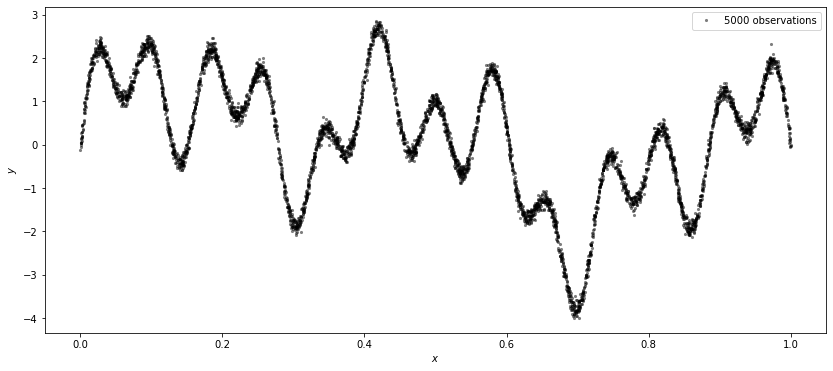

In [12]:
# True latent function
f = lambda x: sum([np.sin(w*np.pi*x) for w in [2, 25, 5, 11]])

N = 5000 # large number of observations

# Random sample locations
X = np.sort(np.random.rand(N)[:,None])
# N noisy observations of the latent function with variance 0.01
y = f(X) + 0.1*np.random.randn(N, 1)

#== Plot samples
plt.figure(figsize=(14, 6))

# Plot points (since there's a lot we make them slightly transparent)
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$y$")
plt.legend(labels=["%d observations" % N]);

Clearly, if we tried to fit full GP regression to this, we would face some problems with the sheer computational resources required for matrix inversion in the Gaussian process equations.

We will use a sparse GP with a small number of inducing points, $M=20$, to try and fit the function. Given the large number of points, we will make some adjustments of the optimiser. We will cap the number of iterations to save time in the lab. These options are given to the `m.optimize()` function. We also add a small amount ($\sigma^2=10^{-6}$) of white noise to our kernel function to avoid any ill-posedness that may occur in the matrix calculations.

<span style="color:red">Teddy Note: perhaps have multiple plots, each of a different lengthscale and maybe use timer to try and show the effect of better inducing point initialisation? </span>

In [13]:
# Number of inducing variables
M = 20

# We define M inducing variables sampled uniformly throughout our input space
Z = np.linspace(0., 1., M)[:, None]
# Z = kmeans(X,M)[0]
# We assume the covariance to be an RBF, and add a white noise term for numerical stability
k = GPy.kern.RBF(1, lengthscale=0.05, name="rbf") + GPy.kern.White(1, name="white")

# Define a sparse GP with Gaussian likelihood
m = GPy.core.SVGP(
    X, y, Z,
    kernel = k,
    likelihood = GPy.likelihoods.Gaussian()
)

# We define the white noise variance to 10^-6 and fix this
m.kern.white.variance = 1.e-6
m.kern.white.fix()

# We limit the number of iterations here, to limit the maximum runtime
# .. We will also allow the optimiser to print progress messages while it is running
m.optimize(max_iters=2500, messages=1)

# Preview our sparse GP model
m

SVGP.,value,constraints,priors
inducing inputs,"(20, 1)",,
sum.rbf.variance,0.08136435463702536,+ve,
sum.rbf.lengthscale,0.01949084436761818,+ve,
sum.white.variance,1e-06,+ve fixed,
Gaussian_noise.variance,0.5709975173043272,+ve,
q_u_chol,"(210, 1)",,
q_u_mean,"(20, 1)",,


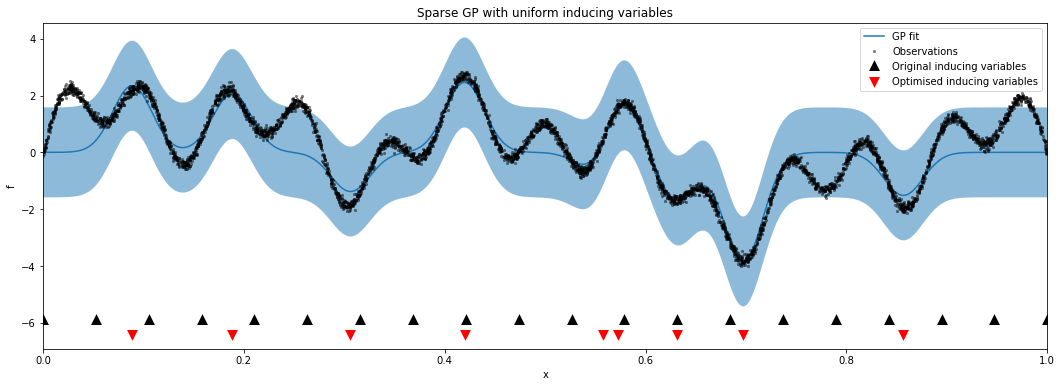

In [14]:
# We create a prediction space defined over the observation space
Xnew = np.linspace(0., 1., 2000)[:, None]

# We predict a likelihood free estimate of our latent functon
mean, Cov = m.predict(Xnew)

# Set up figure environment
plt.figure(figsize=(18, 6))

# Plot the sparse GP prediction
plot_gp(Xnew, mean, Cov)

# Plot observations
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Plot inducing variable locations
# .. Original inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'k^', mew=3)
# .. Optimised inducing variables
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'rv', mew=3)

# Annotate plot
plt.xlim((0., 1.))
plt.title("Sparse GP with uniform inducing variables")
plt.legend(labels=["GP fit", "Observations", "Original inducing variables", "Optimised inducing variables"]);

### Exercise 3

(a) How do you feel about the fit? Based on what you learned in the Lab 1, what changes might you make to the kernel used?

<span style="color:red">Teddy answer: Change lengthscale to 0.01</span>

(b) In the above example, we sampled the inducing variable locations uniformly. However, we can produce a better initialisation, for example using $k$-means clustering. Using `scipy.cluster.vq.kmeans`, initalise the inducing point based on the cluster centroids. How does this improve the fit?

In [15]:
from scipy.cluster.vq import kmeans

In [16]:
# Teddy note : use this instead of default z
kmeans(X,M)[0]

array([[0.15934688],
       [0.30807736],
       [0.36048259],
       [0.47134462],
       [0.20593821],
       [0.11374885],
       [0.89032806],
       [0.58320021],
       [0.25556435],
       [0.63611341],
       [0.97612282],
       [0.79799242],
       [0.84476804],
       [0.93329058],
       [0.07058432],
       [0.5269692 ],
       [0.74309336],
       [0.68939558],
       [0.41502563],
       [0.0230825 ]])